# Entity Resolution and Knowledge Representation

<br>Matheus Schmitz</br>
<br><a href="https://www.linkedin.com/in/matheusschmitz/">LinkedIn</a></br>
<br><a href="https://matheus-schmitz.github.io/">Github Portfolio</a></br>

In [1]:
import rltk
import pandas as pd
import re
from difflib import SequenceMatcher
from tqdm import tqdm

## 1. Load Crawled Data

In [2]:
# RLTK Tokenizer
tokenizer = rltk.CrfTokenizer()

### IMDB

In [3]:
%%capture
df_imdb = pd.read_csv('movies2/csv_files/imdb.csv', encoding='utf-8', error_bad_lines=False)
df_imdb.columns = [x.strip() for x in df_imdb]
df_imdb['ID'] = df_imdb['ID'].astype('str')
df_imdb['name'] = df_imdb['name'].str.strip()
df_imdb['year'] = df_imdb['year'].str.strip()
df_imdb['director'] = df_imdb['director'].str.strip()
df_imdb['writers'] = df_imdb['writers'].str.strip()
df_imdb['actors'] = df_imdb['actors'].str.strip()

In [4]:
df_imdb.head()

,ID,name,year,director,writers,actors
0,1,The Martian,2015,Ridley Scott,Drew Goddard; Andy Weir,Matt Damon; Jessica Chastain; Kristen Wiig
1,2,The Green Inferno,2013,Eli Roth,Guillermo Amoedo; Eli Roth,Lorenza Izzo; Ariel Levy; Aaron Burns
2,3,Everest,2015,Baltasar Kormákur,William Nicholson; Simon Beaufoy,Jason Clarke; Ang Phula Sherpa; Thomas M. Wright
3,4,Sicario,2015,Denis Villeneuve,Taylor Sheridan,Emily Blunt; Josh Brolin; Benicio Del Toro
4,5,The Intern(I),2015,Nancy Meyers,Nancy Meyers,Robert De Niro; Anne Hathaway; Rene Russo


In [5]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9901 entries, 0 to 9900
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        9901 non-null   object
 1   name      9901 non-null   object
 2   year      9901 non-null   object
 3   director  9901 non-null   object
 4   writers   9901 non-null   object
 5   actors    9901 non-null   object
dtypes: object(6)
memory usage: 464.2+ KB


In [6]:
# Even though there are no apparent missing values, I got errors down the line because there are values which are empty stings ''
# Replacing those values with a token
df_imdb.replace('', '<___>', inplace=True)

In [7]:
# RLTK IMDB Record
class IMDBRecord(rltk.Record):
    def __init__(self, raw_object):
        super().__init__(raw_object)
        self.name = 'IMDBRecord'
        
    @property
    def id(self):
        return self.raw_object['ID']    

    @rltk.cached_property
    def name_string(self):
        return self.raw_object['name']

    @rltk.cached_property
    def name_tokens(self):
        return set(tokenizer.tokenize(self.name_string))    
      
    @rltk.cached_property
    def year(self):
        return self.raw_object['year']
    
    @rltk.cached_property
    def director_string(self):
        return self.raw_object['director']

    @rltk.cached_property
    def director_tokens(self):
        return set(tokenizer.tokenize(self.director_string))    
    
    @rltk.cached_property
    def blocking_tokens(self):
        clean_name = ' '.join([self.name_string, self.director_string])
        clean_name = re.sub(r'\bThe\b', '', clean_name)
        clean_name = re.sub(r'\bthe\b', '', clean_name)
        clean_name = re.sub(r'\bof\b', '', clean_name)
        clean_name = re.sub(r"\b's\b", '', clean_name)
        clean_name = re.sub(r'\band\b', '', clean_name)
        clean_name = re.sub(r'\bI\b', '', clean_name)
        clean_name = re.sub(r'\bA\b', '', clean_name)
        clean_name = re.sub(r'\bin\b', '', clean_name)
        clean_name = re.sub(r'\bfor\b', '', clean_name)
        clean_name = re.sub(r'\bon\b', '', clean_name)
        clean_name = re.sub(r'\bwith\b', '', clean_name)
        return set(tokenizer.tokenize(clean_name))

In [8]:
ds_imdb = rltk.Dataset(reader=rltk.DataFrameReader(df_imdb), record_class=IMDBRecord, adapter=rltk.MemoryKeyValueAdapter())
print(type(ds_imdb))
ds_imdb.generate_dataframe().head(5)

<class 'rltk.dataset.Dataset'>


,id,name_string,name_tokens,year,director_string,director_tokens,blocking_tokens
0,1,The Martian,"{Martian, The}",2015,Ridley Scott,"{Scott, Ridley}","{Scott, Ridley, Martian}"
1,2,The Green Inferno,"{Green, Inferno, The}",2013,Eli Roth,"{Eli, Roth}","{Green, Eli, Inferno, Roth}"
2,3,Everest,{Everest},2015,Baltasar Kormákur,"{Baltasar, Kormákur}","{Everest, Baltasar, Kormákur}"
3,4,Sicario,{Sicario},2015,Denis Villeneuve,"{Denis, Villeneuve}","{Denis, Sicario, Villeneuve}"
4,5,The Intern(I),"{(, I, ), The, Intern}",2015,Nancy Meyers,"{Meyers, Nancy}","{(, Meyers, Nancy, ), Intern}"


### TMD

In [9]:
%%capture
df_tmd = pd.read_csv('movies2/csv_files/tmd.csv', encoding='utf-8', error_bad_lines=False)
df_tmd.columns = [x.strip() for x in df_tmd]
df_tmd['ID'] = df_tmd['ID'].astype('str')
df_tmd['title'] = df_tmd['title'].str.strip()
df_tmd['year'] = df_tmd['year'].astype('str', errors='raise')
df_tmd['director(s)'] = df_tmd['director(s)'].str.strip()
df_tmd['writer(s)'] = df_tmd['writer(s)'].str.strip()
df_tmd['actor(s)'] = df_tmd['actor(s)'].str.strip()

In [10]:
df_tmd.head()

,ID,title,year,director(s),writer(s),actor(s)
0,0,Jurassic World,2015.0,Colin Trevorrow,Rick Jaffa;Amanda Silver;Derek Connolly;Colin ...,Chris Pratt;Bryce Dallas Howard;Jake Johnson;J...
1,1,The Martian,2015.0,Ridley Scott,Drew Goddard;Andy Weir,Matt Damon;Jessica Chastain;Kate Mara;Jeff Dan...
2,2,Terminator Genisys,2015.0,Alan Taylor,Laeta Kalogridis;Patrick Lussier,Arnold Schwarzenegger;Jason Clarke;Emilia Clar...
3,3,Mad Max: Fury Road,2015.0,George Miller,George Miller;Nick Lathouris;Brendan McCarthy,Tom Hardy;Charlize Theron;Hugh Keays-Byrne;Nic...
4,4,San Andreas,2015.0,Brad Peyton,Carlton Cuse;Andre Fabrizio;Jeremy Passmore,Alexandra Daddario;Dwayne Johnson;Carla Gugino...


In [11]:
df_tmd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9818 entries, 0 to 9817
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           9818 non-null   object
 1   title        9733 non-null   object
 2   year         9818 non-null   object
 3   director(s)  9551 non-null   object
 4   writer(s)    8758 non-null   object
 5   actor(s)     9479 non-null   object
dtypes: object(6)
memory usage: 460.3+ KB


In [12]:
# This dataset has NaN values
df_tmd.isna().any(axis=1).sum()

1120

In [13]:
# Clean NaN values, using a token very unlikely to be similar to any other sting in the data
df_tmd.fillna('<___>', inplace=True)
df_tmd.replace('', '<___>', inplace=True)
df_tmd.isna().any(axis=1).sum()

0

In [14]:
# RLTK TMD Record
class TMDRecord(rltk.Record):
    def __init__(self, raw_object):
        super().__init__(raw_object)
        self.name = 'IMDBRecord'
        
    @property
    def id(self):
        return self.raw_object['ID']    

    @rltk.cached_property
    def name_string(self):
        return self.raw_object['title']

    @rltk.cached_property
    def name_tokens(self):
        return set(tokenizer.tokenize(self.name_string))
    
    @rltk.cached_property
    def year(self):
        try:
            year = str(int(float(self.raw_object['year'])))
        except:
            year = None
        return year
    
    @rltk.cached_property
    def director_string(self):
        return self.raw_object['director(s)']

    @rltk.cached_property
    def director_tokens(self):
        return set(tokenizer.tokenize(self.director_string))    
    
    @rltk.cached_property
    def blocking_tokens(self):
        clean_name = ' '.join([self.name_string, self.director_string])
        clean_name = re.sub(r'\bThe\b', '', clean_name)
        clean_name = re.sub(r'\bthe\b', '', clean_name)
        clean_name = re.sub(r'\bof\b', '', clean_name)
        clean_name = re.sub(r"\b's\b", '', clean_name)
        clean_name = re.sub(r'\band\b', '', clean_name)
        clean_name = re.sub(r'\bI\b', '', clean_name)
        clean_name = re.sub(r'\bA\b', '', clean_name)
        clean_name = re.sub(r'\bin\b', '', clean_name)
        clean_name = re.sub(r'\bfor\b', '', clean_name)
        clean_name = re.sub(r'\bon\b', '', clean_name)
        clean_name = re.sub(r'\bwith\b', '', clean_name)
        return set(tokenizer.tokenize(clean_name))

In [15]:
ds_tmd = rltk.Dataset(reader=rltk.DataFrameReader(df_tmd), record_class=TMDRecord, adapter=rltk.MemoryKeyValueAdapter())
print(type(ds_tmd))
ds_tmd.generate_dataframe().head(5)

<class 'rltk.dataset.Dataset'>


,id,name_string,name_tokens,year,director_string,director_tokens,blocking_tokens
0,0,Jurassic World,"{World, Jurassic}",2015,Colin Trevorrow,"{Trevorrow, Colin}","{World, Trevorrow, Colin, Jurassic}"
1,1,The Martian,"{Martian, The}",2015,Ridley Scott,"{Scott, Ridley}","{Scott, Ridley, Martian}"
2,2,Terminator Genisys,"{Terminator, Genisys}",2015,Alan Taylor,"{Alan, Taylor}","{Alan, Terminator, Genisys, Taylor}"
3,3,Mad Max: Fury Road,"{Fury, Max, Road, Mad, :}",2015,George Miller,"{George, Miller}","{Fury, Max, Road, Mad, :, Miller, George}"
4,4,San Andreas,"{Andreas, San}",2015,Brad Peyton,"{Brad, Peyton}","{Peyton, Brad, Andreas, San}"


## 2. Blocking for Efficient Candidate Evaluation

### Generate Blocks

In [16]:
# Generate blocks from tokens
token_blocker = rltk.TokenBlockGenerator()
blocks = token_blocker.generate(
    token_blocker.block(ds_imdb, property_='blocking_tokens'),
    token_blocker.block(ds_tmd, property_='blocking_tokens'))
print(type(blocks))

# Save block as csv
with open('Matheus_Schmitz_hw03_blocked.csv', 'w') as blocked_data:
    for match, imdb_id, tmd_id in blocks.pairwise(ds_imdb, ds_tmd):
        blocked_data.write(f'{imdb_id},{tmd_id}\n')

<class 'rltk.blocking.block.Block'>


### Ground Truth

In [17]:
# Load Ground Truth
df_truth = pd.read_csv('movies2/csv_files/labeled_data.csv', skiprows=5)
num_positive_matches = df_truth[df_truth['class_label'] == 1].shape[0]
print(f'df_truth.shape: {df_truth.shape}')
print(f'Match samples: {num_positive_matches}')
df_truth.head()

df_truth.shape: (400, 8)
Match samples: 256


,_id,ltable.ID,rtable.ID,ltable.title,ltable.year,rtable.title,rtable.year,class_label
0,1,1,1,The Martian,2015,The Martian,2015,1
1,2728,5,61,The Intern(I),2015,The Intern,2015,1
2,21244,32,283,Me and Earl and the Dying Girl,2015,Me and Earl and the Dying Girl,2015,1
3,23758,36,549,The Hunger Games: Mockingjay - Part 2,2015,The Hunger Games: Mockingjay - Part 2,2015,1
4,24245,37,12,The Maze Runner,2014,Maze Runner: The Scorch Trials,2015,0


In [51]:
gt = rltk.GroundTruth()

# Left table is IMDB, right is TMD
for idx, row in df_truth.iterrows():
    record_imdb = ds_imdb.get_record(str(row['ltable.ID']))
    record_tmd = ds_tmd.get_record(str(row['rtable.ID']))
    if row['class_label'] == 1:
        gt.add_positive(record_imdb.raw_object['ID'],record_tmd.raw_object['ID'])
    if row['class_label'] == 0:
        gt.add_negative(record_imdb.raw_object['ID'],record_tmd.raw_object['ID'])
print(f'df_truth.shape: {df_truth.shape}')
print(f'gt.shape: {gt.generate_dataframe().shape}')    
gt.save('groundtruth.csv')
gt.generate_dataframe().head()

df_truth.shape: (400, 8)
gt.shape: (400, 3)


,id1,id2,label
0,1,1,True
1,5,61,True
2,32,283,True
3,36,549,True
4,37,12,False


### Create RLTK from Labeled Samples

In [19]:
# Generate a Dataframe containing only labeled IMDB samples
ids_labeled_imdb = df_truth[df_truth['class_label'] == 1]['ltable.ID'].values
df_imdb_labeled = df_imdb[df_imdb['ID'].astype('int').isin(ids_labeled_imdb)]
print(f'df_imdb_labeled.shape: {df_imdb_labeled.shape}')
      
# Convert the dataframe to a RLTK dataset
ds_imdb_labeled = rltk.Dataset(reader=rltk.DataFrameReader(df_imdb_labeled), record_class=IMDBRecord, adapter=rltk.MemoryKeyValueAdapter())
print(f'ds_imdb_labeled.shape: {ds_imdb_labeled.generate_dataframe().shape}')

df_imdb_labeled.shape: (256, 6)
ds_imdb_labeled.shape: (256, 7)


In [20]:
# Generate a Dataframe containing only labeled TMD samples
ids_labeled_tmd = df_truth[df_truth['class_label'] == 1]['rtable.ID'].values
df_tmd_labeled = df_tmd[df_tmd['ID'].astype('int').isin(ids_labeled_tmd)]
print(f'df_tmd_labeled.shape: {df_tmd_labeled.shape}')

# Convert the dataframe to a RLTK dataset
ds_tmd_labeled = rltk.Dataset(reader=rltk.DataFrameReader(df_tmd_labeled), record_class=TMDRecord, adapter=rltk.MemoryKeyValueAdapter())
ds_tmd_labeled.generate_dataframe().shape
print(f'ds_tmd_labeled.shape: {ds_tmd_labeled.generate_dataframe().shape}')

df_tmd_labeled.shape: (256, 6)
ds_tmd_labeled.shape: (256, 7)


### Reduction Ratio

In [21]:
# Extract all record pairs from the block
record_pairs = rltk.get_record_pairs(ds_imdb, ds_tmd, block=blocks)

# Get the total number of record pairs generated
compared_pairs = len(list(record_pairs))

# Get the number of elements in each rltk.Dataset
tally_imdb = ds_imdb.generate_dataframe().shape[0]
tally_tmd = ds_tmd.generate_dataframe().shape[0]

# Calculate the total number of pairs if both datasets were to be compared without any blocking (eg: a double for loop)
tally_unblocked = tally_imdb * tally_tmd

# Calculate how much smaller the blocked pairings are
reduction_ratio = compared_pairs / tally_unblocked

# Calculate the reduction ratio (the inverse of the )
reduction_ratio = 1 - reduction_ratio
print(f'Reduction Ratio: {reduction_ratio:.5f}')

Reduction Ratio: 0.96839


### Pair Completness

In [22]:
# Build a dictionary mapping the IMDB ID to the TMD ID
IMDB_to_TMD = {}
TMD_to_IMDB = {}
total_true_matches = 0.0
for imdb_id, tmd_id, label in gt:
    if label == True:
        IMDB_to_TMD[imdb_id] = tmd_id
        TMD_to_IMDB[tmd_id] = imdb_id
        total_true_matches += 1

# For each item in the dict built from the blocked ground truth, check if there is a matching IMDB x TMD pair
matches_counter = 0.0
for block_id, imdb_id, tmd_id in blocks.pairwise(ds_imdb_labeled, ds_tmd_labeled):
    if imdb_id in IMDB_to_TMD.keys() and IMDB_to_TMD[imdb_id] == tmd_id:
        matches_counter += 1
        # Delete the element from IMDB_to_TMD otherwise I would double/triple/etc. count items with more than 1 candidate match
        # Because when an IMDB item has more than 1 candidate match, it appears X-many times in blocks.pairwise
        del IMDB_to_TMD[imdb_id]

# Calculate pairs completness
pairs_completness = matches_counter / total_true_matches
print('Pairs Completness:', pairs_completness)

Pairs Completness: 1.0


## 3. Create Similarity Model & Predict Entity Matches

Sequence similarity: https://docs.python.org/2/library/difflib.html#sequencematcher-objects

In [39]:
def name_similarity(imdb_tuple, tmd_tuple):
    imdb_name = imdb_tuple.name_string.strip().lower()
    tmd_name = tmd_tuple.name_string.strip().lower()
    #longest_seq = SequenceMatcher(None, imdb_name, tmd_name).find_longest_match(0, len(imdb_name), 0, len(tmd_name)).size
    #similarity = (2*longest_seq)/(len(imdb_name)+len(tmd_name)) # same as the .ratio() method below
    similarity = SequenceMatcher(None, imdb_name, tmd_name).ratio()

    # Movie sequels (Ice Age x Ice Age 2) and movies with short names were giving too many wrong matches, so penalize them
    penalties = sum([imdb_name[-1].isnumeric(), 
                     tmd_name[-1].isnumeric(),
                     len(imdb_name)<=6,
                     len(tmd_name)<=6])

    return similarity * (0.9**penalties)

In [40]:
def director_similarity(imdb_tuple, tmd_tuple):
    imdb_director = imdb_tuple.director_string.strip().lower()
    tmd_director = tmd_tuple.director_string.strip().lower()
    similarity = SequenceMatcher(None, imdb_director, tmd_director).ratio() 
    
    return similarity

In [41]:
def year_similarity(imdb_tuple, tmd_tuple):
    # IMDB
    try:
        imdb_year = int(float(imdb_tuple.year))
    except:
        return None
    
    # TMD
    try:
        tmd_year = int(float(tmd_tuple.year))
    except:
        return None

    similarity = 1 /(1 + abs(imdb_year-tmd_year))
    return similarity

In [43]:
def elementwise_similarity(imdb_tuple, tmd_tuple, match_threshold=0.85):
    sim_name = name_similarity(imdb_tuple, tmd_tuple)
    sim_director = director_similarity(imdb_tuple, tmd_tuple)
    sim_year = year_similarity(imdb_tuple, tmd_tuple)

    if sim_year != None:
        element_similarity = ((4/6) * sim_name) + ((1/6) * sim_director) + ((1/6) * sim_year)
    else:
        element_similarity = ((4.5/6) * sim_name) + ((1.5/6) * sim_director)

    return element_similarity > match_threshold, element_similarity

### Evaluate Predictions & Find Best Threshold

In [46]:
summary_df = pd.DataFrame()

THRESHOLDS = [T/100 if T != 100 else 0.99 for T in range(0, 101, 5)]

# Iterate through various thresholds to find the best F1-Score
for T in THRESHOLDS:
    
    # Populate trial object
    trial = rltk.Trial(gt)
    candidate_pairs = rltk.get_record_pairs(ds_imdb, ds_tmd, ground_truth=gt)
    for imdb_tuple, tmd_tuple in candidate_pairs:
        result, confidence = elementwise_similarity(imdb_tuple, tmd_tuple, match_threshold=T)
        trial.add_result(imdb_tuple, tmd_tuple, result, confidence)

    # Evaluate and obtain a confusion matrix
    trial.evaluate()
    summary_df.at[T, 'TP'] = len(trial.true_positives_list)
    summary_df.at[T, 'FP'] = len(trial.false_positives_list)
    summary_df.at[T, 'TN'] = len(trial.true_negatives_list)
    summary_df.at[T, 'FN'] = len(trial.false_negatives_list)

    summary_df.at[T, 'TPR'] = trial.true_positives
    summary_df.at[T, 'FPR'] = trial.false_positives
    summary_df.at[T, 'TNR'] = trial.true_negatives
    summary_df.at[T, 'FNR'] = trial.false_negatives

    summary_df.at[T, 'Precision'] = summary_df.at[T, 'TP'] / (summary_df.at[T, 'TP'] + summary_df.at[T, 'FP'])
    summary_df.at[T, 'Recall'] = summary_df.at[T, 'TP'] / (summary_df.at[T, 'TP'] + summary_df.at[T, 'FN'])
    summary_df.at[T, 'F1-Score']  = (2 * (summary_df.at[T, 'Precision'] * summary_df.at[T, 'Recall'])) / (summary_df.at[T, 'Precision'] + summary_df.at[T, 'Recall'])

summary_df

,TP,FP,TN,FN,TPR,FPR,TNR,FNR,Precision,Recall,F1-Score
0.00,256.0,144.0,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.640000,1.000000,0.780488
0.05,256.0,144.0,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.640000,1.000000,0.780488
0.10,256.0,144.0,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.640000,1.000000,0.780488
0.15,256.0,144.0,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.640000,1.000000,0.780488
0.20,256.0,144.0,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.640000,1.000000,0.780488
0.25,256.0,144.0,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.640000,1.000000,0.780488
0.30,256.0,144.0,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.640000,1.000000,0.780488
0.35,256.0,136.0,8.0,0.0,1.000000,0.944444,0.055556,0.000000,0.653061,1.000000,0.790123
0.40,256.0,114.0,30.0,0.0,1.000000,0.791667,0.208333,0.000000,0.691892,1.000000,0.817891
0.45,256.0,82.0,62.0,0.0,1.000000,0.569444,0.430556,0.000000,0.757396,1.000000,0.861953


In [47]:
# Find the threshold which obtains the highest F1-Score
summary_df[summary_df['F1-Score'] == summary_df['F1-Score'].max()]

,TP,FP,TN,FN,TPR,FPR,TNR,FNR,Precision,Recall,F1-Score
0.85,254.0,1.0,143.0,2.0,0.992188,0.006944,0.993056,0.007812,0.996078,0.992188,0.994129


### Link Entities Based on F1-Score

In [44]:
# Predict matches for all pairs in the blocked data
RECALCULATE = True
if RECALCULATE:
    
    with open('Matheus_Schmitz_hw03_el.csv', 'w') as predictions_full:
        for block_id, imdb_id, tmd_id in tqdm(blocks.pairwise(ds_imdb, ds_tmd)):
            
            match , similarity = elementwise_similarity(ds_imdb.get_record(imdb_id),
                                                        ds_tmd.get_record(tmd_id),
                                                        match_threshold=0.85)

            if match:
                predictions_full.write(f'{imdb_id},{tmd_id},1\n')
            else:
                predictions_full.write(f'{imdb_id},{tmd_id},0\n')

In [45]:
# Predict matches for the pairs inthe labeled dataset
RECALCULATE = True
if RECALCULATE:

    with open('Matheus_Schmitz_hw03_el_labeled.csv', 'w') as predictions_labeled:
        for idx, row in tqdm(df_truth.iterrows()):
            imdb_tuple = ds_imdb.get_record(str(row['ltable.ID']))
            tmd_tuple = ds_tmd.get_record(str(row['rtable.ID']))

            match , similarity = elementwise_similarity(imdb_tuple, tmd_tuple, match_threshold=0.85)

            if match:
                predictions_labeled.write(f'{imdb_id},{tmd_id},1\n')
            else:
                predictions_labeled.write(f'{imdb_id},{tmd_id},0\n')

## 4. Define Ontology

<br>@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
<br>@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
<br>@prefix xml: <http://www.w3.org/XML/1998/namespace> .
<br>@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
<br>@prefix schema: <http://schema.org/> .
<br>@prefix my_ns: <http://inf558.org/myfakenamespace#> .
<br>
<br>
<br>#### Movie Class ####
<br>my_ns:Movie a schema:Class ;
<br>    rdfs:subClassOf schema:Movie ;
<br>    schema:name schema:text ;        # movie name
<br>    schema:datePublished xsd:gYear ; # year of release
<br>    schema:director schema:Person ;  # movie directors
<br>    schema:author schema:Person ;    # movie writers
<br>    schema:actor schema:Person ;     # movie actors

## 5. Join Datasets & Merge Linked Entities

In [48]:
import rdflib
from rdflib import URIRef, Literal, Namespace
from rdflib.namespace import RDF, RDFS, XSD

MYNS = Namespace('http://inf558.org/myfakenamespace#')
SCHEMA = Namespace("https://schema.org/")

# Initliaze the graph
g = rdflib.Graph()

# Bind namespace and prefixes
g.bind('my_ns', MYNS)
g.bind('schema', SCHEMA)
g.bind('rdf', RDF)
g.bind('rdfs', RDFS)
g.bind('xsd', XSD)

In [49]:
# Load predictions to be used in populating the RDF
predictions_df = pd.read_csv('Matheus_Schmitz_hw03_el.csv', header=None, names=['IMDB_ID', 'TMD_ID', 'LABEL'])
print(f'predictions_df.shape: {predictions_df.shape}')
predicted_matches = predictions_df['LABEL'].sum()
print(f'predicted matches: {predicted_matches}  [{100*predicted_matches/predictions_df.shape[0]:.2f} %]')
predictions_df.head()

predictions_df.shape: (3072442, 3)
predicted matches: 27506  [0.90 %]


,IMDB_ID,TMD_ID,LABEL
0,4524,482,0
1,4524,2770,0
2,4524,6658,0
3,4524,5503,0
4,4524,1,0


In [50]:
# Populate the RDF with predictions with a positive (1) label
for idx, row in tqdm(predictions_df[predictions_df['LABEL']==1].iterrows(), 
                     total=predictions_df[predictions_df['LABEL']==1].shape[0]):
    
    # URI
    node_uri = URIRef(str(row['IMDB_ID']))
    g.add((node_uri, RDF.type, MYNS.Movie))

    # Name
    name_imdb = str(df_imdb[df_imdb['ID'] == str(row['IMDB_ID'])]['name'].values[0])
    name_tmd = str(df_tmd[df_tmd['ID'] == str(row['TMD_ID'])]['title'].values[0])
    name = name_imdb if name_imdb != '<___>' else name_tmd if name_tmd != '<___>' else None
    g.add((node_uri, SCHEMA.name, Literal(name, datatype=SCHEMA.text)))

    # Year
    year_imdb = str(df_imdb[df_imdb['ID'] == str(row['IMDB_ID'])]['year'].values[0])
    year_tmd = str(df_tmd[df_tmd['ID'] == str(row['TMD_ID'])]['year'].values[0])
    year = int(float(year_imdb)) if year_imdb != '<___>' else int(float(year_tmd)) if year_tmd != '<___>' else None
    g.add((node_uri, SCHEMA.datePublished, Literal(year, datatype=XSD.gYear)))

    # Director(s)
    director_imdb = df_imdb[df_imdb['ID'] == str(row['IMDB_ID'])]['director'].values[0].split(';')
    director_imdb = [name.strip() for name in director_imdb if name != '<___>']
    director_tmd = df_tmd[df_tmd['ID'] == str(row['TMD_ID'])]['director(s)'].values[0].split(';')
    director_tmd = [name.strip() for name in director_tmd if name != '<___>']
    directors = list(set(director_imdb + director_tmd))
    [g.add((node_uri, SCHEMA.director, Literal(director, datatype=SCHEMA.Person))) for director in directors]

    # Writer(s)
    writers_imdb = df_imdb[df_imdb['ID'] == str(row['IMDB_ID'])]['writers'].values[0].split(';')
    writers_imdb = [name.strip() for name in writers_imdb if name != '<___>']
    writers_tmd = df_tmd[df_tmd['ID'] == str(row['TMD_ID'])]['writer(s)'].values[0].split(';')
    writers_tmd = [name.strip() for name in writers_tmd if name != '<___>']
    writers = list(set(writers_imdb + writers_tmd))
    [g.add((node_uri, SCHEMA.author, Literal(writer, datatype=SCHEMA.Person))) for writer in writers]
   
    # Actor(s)    
    actors_imdb = df_imdb[df_imdb['ID'] == str(row['IMDB_ID'])]['actors'].values[0].split(';')
    actors_imdb = [name.strip() for name in actors_imdb if name != '<___>']
    actors_tmd = df_tmd[df_tmd['ID'] == str(row['TMD_ID'])]['actor(s)'].values[0].split(';')
    actors_tmd = [name.strip() for name in actors_tmd if name != '<___>']
    actors = list(set(actors_imdb + actors_tmd))
    [g.add((node_uri, SCHEMA.actor, Literal(actor, datatype=SCHEMA.Person))) for actor in actors]

# Save to disk using turtle format
g.serialize('Matheus_Schmitz_hw03_triples.ttl.', format="turtle")

100%|████████████████████████████████████████████████████████████████████████████| 27506/27506 [06:27<00:00, 70.94it/s]


## 6. Visualize Resulting Ontology

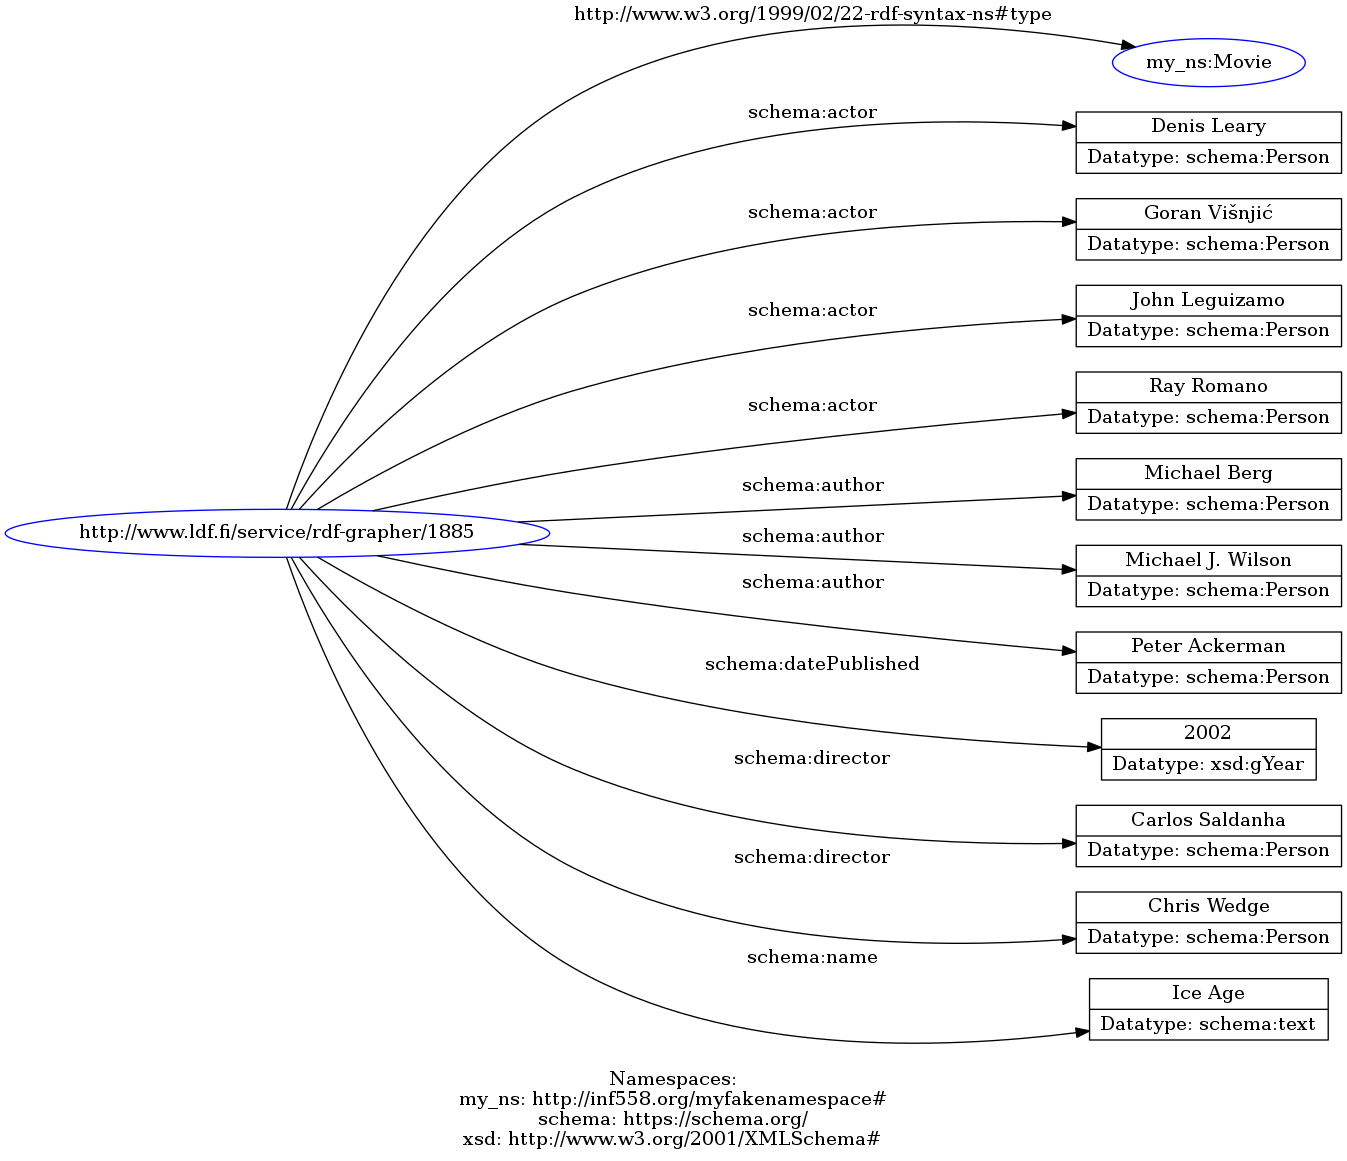